In [2]:
!pip cache purge
!pip install --no-cache-dir stable-baselines3 onnx

Files removed: 0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 310.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 261.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 175.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 243.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 372.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 209.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 190.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 131.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 131.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 155.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 154.2 MB/s eta 0:00:00
  Attempti

In [3]:
!pip install --upgrade shimmy gymnasium


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.5/965.5 kB 27.2 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.0.0
    Uninstalling gymnasium-1.0.0:
      Successfully uninstalled gymnasium-1.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
stable-baselines3 2.5.0 requires gymnasium<1.1.0,>=0.29.1, but you have gymnasium 1.1.0 which is incompatible.


In [4]:
import importlib

packages = ["stable_baselines3", "gym", "numpy", "torch", "onnx"]

for package in packages:
    try:
        importlib.import_module(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"{package} is NOT installed.")


stable_baselines3 is already installed.
gym is already installed.
numpy is already installed.
torch is already installed.
onnx is already installed.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Create RL Environment for SPWM

We define a custom environment where:

- **State** = Modulation Index 𝑀 (continuous value between 0 and 1.2)
- **Action** = Generate a 1000-length SPWM sequence (binary actions: 0 or 1)
- **Reward** = Compare generated waveform with ideal inverter output using voltage regulation error or harmonic distortion.

In [7]:
import gym
import numpy as np
import pandas as pd
import torch
from gym import spaces
from stable_baselines3 import PPO

# Load dataset from Google Drive (replace with your actual file path)
dataset_path = "/content/drive/My Drive/datasets/spwm_dataset_60kHz.csv"
data = pd.read_csv(dataset_path, header=None).values

# Extract modulation indices (first column) and corresponding SPWM waveforms (remaining columns)
modulation_indices = data[:, 0]  # First column
spwm_waveforms = data[:, 1:]     # Remaining columns (1000 per row)

class SPWMEnv(gym.Env):
    def __init__(self):
        super(SPWMEnv, self).__init__()

        # Define the observation space (modulation index)
        self.observation_space = spaces.Box(low=0.0, high=1.2, shape=(1,), dtype=np.float32)

        # Define action space (1000 binary switching decisions)
        self.action_space = spaces.MultiBinary(1000)

        # Store dataset in environment
        self.dataset = list(zip(modulation_indices, spwm_waveforms))
        self.current_index = None  # Track current data sample

    def step(self, action):
        """Compute reward by comparing action with real dataset SPWM."""
        if self.current_index is None:
            raise RuntimeError("Environment reset() was not called before step()!")

        mod_index, real_spwm = self.dataset[self.current_index]

        # Compute reward: Minimize MSE between generated action and real SPWM
        mse_error = np.mean((real_spwm - action) ** 2)
        reward = -mse_error  # Lower MSE is better

        done = True  # One step per episode
        return np.array([mod_index], dtype=np.float32), reward, done, {}

    def reset(self):
        """Select a random modulation index and its corresponding real SPWM waveform."""
        self.current_index = np.random.randint(len(self.dataset))
        mod_index, _ = self.dataset[self.current_index]
        return np.array([mod_index], dtype=np.float32)

## Train the RL Model
We'll use Proximal Policy Optimization (PPO) from Stable-Baselines3.

In [8]:
from stable_baselines3 import PPO

# Create environment
env = SPWMEnv()

# Initialize RL Model
model = PPO("MlpPolicy", env, verbose=1)

# Train for 100,000 steps
model.learn(total_timesteps=100000)




Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -0.497   |
| time/              |          |
|    fps             | 717      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1          |
|    ep_rew_mean          | -0.496     |
| time/                   |            |
|    fps                  | 558        |
|    iterations           | 2          |
|    time_elapsed         | 7          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.08376449 |
|    clip_fraction        | 0.525      |
|    clip_range           | 0.2        |
|    entropy_loss         | -693       |
|    explained_variance   | -3.47      |
|    learning_rate        | 0.0003     |
|   

In [9]:
# Save trained model
model.save("/content/drive/My Drive/models/spwm_rl_model_1")
print("✅ Model saved as spwm_rl_model_1.zip")

# from google.colab import files
# files.download("spwm_rl_model_1.zip")
# print("✅ Model downloaded successfully!")

✅ Model saved as spwm_rl_model_1.zip


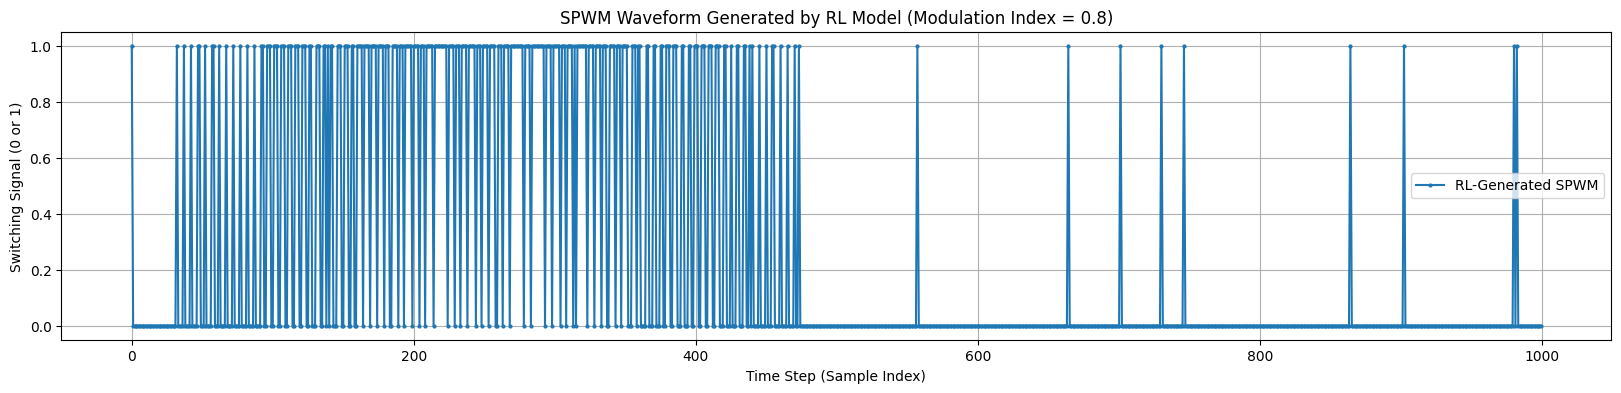

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO

# Load trained model
model = PPO.load("/content/drive/My Drive/models/spwm_rl_model_1")

# Define a fixed test modulation index
test_modulation_index = np.array([[0.8]])  # PPO expects a 2D array

# Predict the SPWM waveform using the RL model
action, _ = model.predict(test_modulation_index)

# Plot the generated SPWM waveform
plt.figure(figsize=(20, 4))
plt.plot(action[0], label="RL-Generated SPWM", linestyle='-', marker='o', markersize=2)
plt.title("SPWM Waveform Generated by RL Model (Modulation Index = 0.8)")
plt.xlabel("Time Step (Sample Index)")
plt.ylabel("Switching Signal (0 or 1)")
plt.legend()
plt.grid(True)
plt.show()
